# Attention Unet model


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Pre-Processing
import os
import numpy as np
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Activation, Multiply, SeparableConv2D
from tensorflow.keras.callbacks import EarlyStopping
# Loss
import tensorflow.keras.backend as K
# Plot
import matplotlib.pyplot as plt


In [3]:
print(os.getcwd())
os.chdir("/content/drive/MyDrive/BTP")
print(os.getcwd())

/content
/content/drive/MyDrive/BTP


## Data loader


In [4]:
def read_image(file_path, size):
    """ Read image in grayscale format, resize and Expand dimensions:

    Args:
        file_path (String): The path to image file
        size: (height, width) of resized image

    Returns:
        numpy.ndarray: A 3-Dimentional array of image in (height,width,channel) format
    """
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size, interpolation=cv2.INTER_NEAREST) # INTER_NEAREST will not result in color change
    image = np.expand_dims(image, axis=-1)
    return image

In [5]:
def get_train_data(X_train_path: str, y_train_path: str , start_index: int, end_index: int):
    """
    Reads files with the extension '.tif' in sorted order and appends them to the output array.

    Assumptions:
        Image Files in both OCT and Reference images are of same name.

    Parameters:
        X_train_path (string): The path to folder containing OCT scan images.
        y_train_path (string): The path to folder containing Reference images.
        start_index (int): The starting index of the array to append files.
        end_index (int): The ending index (exclusive) of the array to append files.

    Returns:
        numpy.ndarray: An array containing the contents of the '.tif' files.

    Example:
        # To read and append '.tif' files from index 0 to 9 (10 in number)
        output_array = read_tif_files_sorted(0, 10)
    """
    start_index = start_index if start_index >= 0 else 0    # Start index is 0
    end_index = end_index if end_index <= 6936 else 6936    # Total number of images in dataset

    files = sorted(os.listdir(X_train_path))
    X_train = []
    y_train = []

    for i in range(start_index, end_index):
        X_file_path = os.path.join(X_train_path, files[i])
        y_file_path = os.path.join(y_train_path, files[i])

        print(i, X_file_path)
        print(i, y_file_path)

        image = read_image(X_file_path, (128, 256)) #------------------------------------------------> Shape
        X_train.append(image)

        image = read_image(y_file_path, (128, 256)) #------------------------------------------------> Shape
        y_train.append(image)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    print("X_Train_shape:", X_train.shape)
    print("y_Train_shape:", y_train.shape)


    return X_train,y_train

In [6]:
X_train_path = './Images/OCT'
y_train_path = './Images/Reference'
X_train, y_train = get_train_data(X_train_path,y_train_path, 0, 256)
y_train = y_train // 85

0 ./Images/OCT/01_000.tif
0 ./Images/Reference/01_000.tif
1 ./Images/OCT/01_001.tif
1 ./Images/Reference/01_001.tif
2 ./Images/OCT/01_002.tif
2 ./Images/Reference/01_002.tif
3 ./Images/OCT/01_003.tif
3 ./Images/Reference/01_003.tif
4 ./Images/OCT/01_004.tif
4 ./Images/Reference/01_004.tif
5 ./Images/OCT/01_005.tif
5 ./Images/Reference/01_005.tif
6 ./Images/OCT/01_006.tif
6 ./Images/Reference/01_006.tif
7 ./Images/OCT/01_007.tif
7 ./Images/Reference/01_007.tif
8 ./Images/OCT/01_008.tif
8 ./Images/Reference/01_008.tif
9 ./Images/OCT/01_009.tif
9 ./Images/Reference/01_009.tif
10 ./Images/OCT/01_010.tif
10 ./Images/Reference/01_010.tif
11 ./Images/OCT/01_011.tif
11 ./Images/Reference/01_011.tif
12 ./Images/OCT/01_012.tif
12 ./Images/Reference/01_012.tif
13 ./Images/OCT/01_013.tif
13 ./Images/Reference/01_013.tif
14 ./Images/OCT/01_014.tif
14 ./Images/Reference/01_014.tif
15 ./Images/OCT/01_015.tif
15 ./Images/Reference/01_015.tif
16 ./Images/OCT/01_016.tif
16 ./Images/Reference/01_016.tif


In [7]:
np.unique(y_train)

array([0, 1, 2], dtype=uint8)

In [8]:
# for i in range(len(y_train)):
#     if np.any(np.isin(np.unique(y_train[i]),43)):
#         print(i)

In [9]:
y_train = to_categorical(y_train, num_classes=4)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [10]:
# Print the shapes of the resulting datasets
print("Training Data Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nValidation Data Shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("\nTesting Data Shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training Data Shapes:
X_train: (183, 256, 128, 1)
y_train: (183, 256, 128, 4)

Validation Data Shapes:
X_val: (21, 256, 128, 1)
y_val: (21, 256, 128, 4)

Testing Data Shapes:
X_test: (52, 256, 128, 1)
y_test: (52, 256, 128, 4)


In [11]:
def conv_block(input_tensor, num_filters):
    encoder = SeparableConv2D(num_filters, (3, 3), padding='same', activation='relu')(input_tensor)
    encoder = SeparableConv2D(num_filters, (3, 3), padding='same', activation='relu')(encoder)
    return encoder

In [12]:
def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder


In [13]:
def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([concat_tensor, decoder], axis=-1)
    decoder = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2D(num_filters, (3, 3), padding='same', activation='relu')(decoder)
    return decoder

In [14]:
def attention_gate(x, g):
    """
    Implements an attention gate function.

    Arguments:
    x -- Input tensor (e.g., feature map)
    g -- Gate tensor (e.g., context tensor)

    Returns:
    gated_output -- Output tensor after applying attention gating
    """

    # Calculate attention coefficients
    attention_weights = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding='same')(tf.keras.layers.concatenate([x, g]))

    # Apply attention gating
    gated_output = tf.multiply(x, attention_weights)

    return gated_output

In [15]:
def unet_model(input_shape, num_classes, depth=4):
    inputs = Input(shape=input_shape)

    # Encoder
    encoder_outputs = []
    encoder = inputs
    for i in range(depth):
        encoder, encoder_out = encoder_block(encoder, 64 * (2 ** i))
        encoder_outputs.append(encoder_out)

    # Bridge
    bridge = conv_block(encoder, 1024)

    # Decoder
    decoder = bridge
    for i in reversed(range(depth)):
        decoder = decoder_block(decoder, encoder_outputs[i], 64 * (2 ** i))
        decoder = attention_gate(decoder, encoder_outputs[i])

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(decoder)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


In [16]:
input_shape = (256, 128, 1)
num_classes = 4
depth = 4
model = unet_model(input_shape, num_classes, depth)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 128, 1)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 256, 128, 64)         137       ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 separable_conv2d_1 (Separa  (None, 256, 128, 64)         4736      ['separable_conv2d[0][0]']    
 bleConv2D)                                                                                       
                                                                                              

In [17]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

In [18]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [19]:
def combined_loss(y_true, y_pred, alpha=0.5):
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)  # Binary Cross-Entropy loss
    dice = dice_loss(y_true, y_pred)
    return alpha * bce + (1 - alpha) * dice

In [20]:
early_stopping = EarlyStopping(monitor='val_dice_coefficient', min_delta=0.001, patience=10, mode='max', verbose=1)

In [21]:
model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coefficient])

In [22]:
history = model.fit(X_train, y_train, batch_size=8, epochs=5, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/5
23/23 [==============================] - 472s 20s/step - loss: 0.1233 - dice_coefficient: 0.9493 - val_loss: 0.0184 - val_dice_coefficient: 0.9961
Epoch 2/5
23/23 [==============================] - 450s 20s/step - loss: 0.0215 - dice_coefficient: 0.9929 - val_loss: 0.0092 - val_dice_coefficient: 0.9963
Epoch 3/5
23/23 [==============================] - 433s 19s/step - loss: 0.0227 - dice_coefficient: 0.9929 - val_loss: 0.0133 - val_dice_coefficient: 0.9963
Epoch 4/5
23/23 [==============================] - 447s 20s/step - loss: 0.0188 - dice_coefficient: 0.9929 - val_loss: 0.0112 - val_dice_coefficient: 0.9964
Epoch 5/5
23/23 [==============================] - 441s 19s/step - loss: 0.0163 - dice_coefficient: 0.9929 - val_loss: 0.0092 - val_dice_coefficient: 0.9964


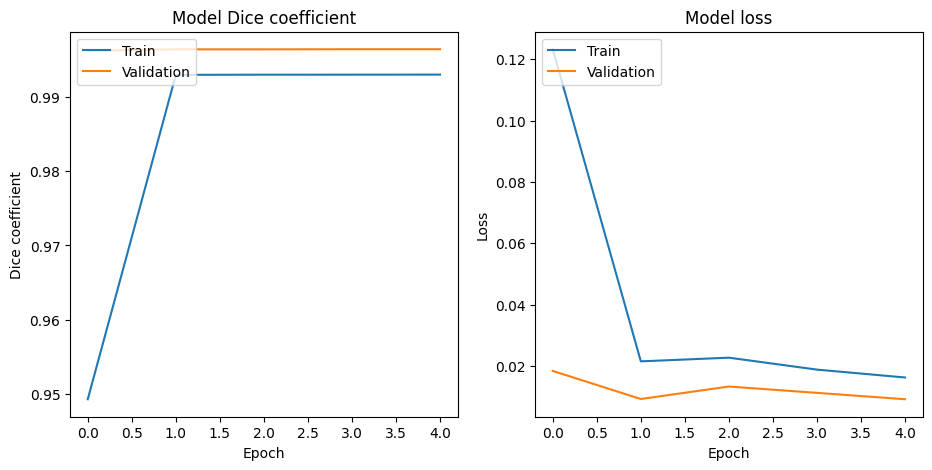

In [23]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model Dice coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [24]:
# Evaluate the model on the test data
loss, dice_coefficient  = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Dice Coefficient :", dice_coefficient )

2/2 [==============================] - 35s 14s/step - loss: 0.0109 - dice_coefficient: 0.9953
Test Loss: 0.010888461954891682
Test Dice Coefficient : 0.995326578617096


In [25]:
model.save("./Models/Model_with_dice_" + str(dice_coefficient) + ".h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
X_test.shape

(52, 256, 128, 1)

In [27]:
predictions = model.predict(X_test)

2/2 [==============================] - 36s 13s/step


In [28]:
np.shape(predictions)

(52, 256, 128, 4)

In [29]:
np.unique(predictions)

array([2.7973519e-26, 3.5686804e-26, 5.3296041e-26, ..., 9.9999970e-01,
       9.9999982e-01, 9.9999994e-01], dtype=float32)

In [30]:
predictions

array([[[[9.98884797e-01, 5.57892374e-04, 3.54032731e-04,
          2.03367686e-04],
         [9.99992907e-01, 4.34734284e-06, 2.21198729e-06,
          4.93254277e-07],
         [9.99999344e-01, 4.34514249e-07, 1.24815202e-07,
          2.91238571e-08],
         ...,
         [9.99999821e-01, 1.58143123e-07, 4.98677828e-08,
          1.15692194e-08],
         [9.99997437e-01, 1.71196780e-06, 6.62274658e-07,
          1.75971650e-07],
         [9.99471605e-01, 3.41284409e-04, 1.39169599e-04,
          4.78421571e-05]],

        [[9.99993265e-01, 5.16951104e-06, 5.56774808e-07,
          9.65181925e-07],
         [9.99999940e-01, 2.24847096e-09, 7.90272361e-11,
          5.59409845e-11],
         [9.99999940e-01, 5.90305929e-11, 1.11818963e-12,
          5.30667415e-13],
         ...,
         [9.99999940e-01, 8.84625359e-12, 4.59275359e-13,
          2.21916628e-13],
         [9.99999940e-01, 3.99115824e-10, 3.92386436e-11,
          1.19048903e-11],
         [9.99997914e-01, 1.2970003

In [37]:
predictions = np.argmax(predictions, axis=-1)
np.unique(predictions)

array([0])

In [32]:
predictions

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [33]:
np.shape(predictions)

(52, 256, 128)

In [34]:
y_test = np.argmax(y_test, axis=-1)
np.unique(y_test)

array([0, 1, 2])

In [35]:
np.unique(y_test)

array([0, 1, 2])

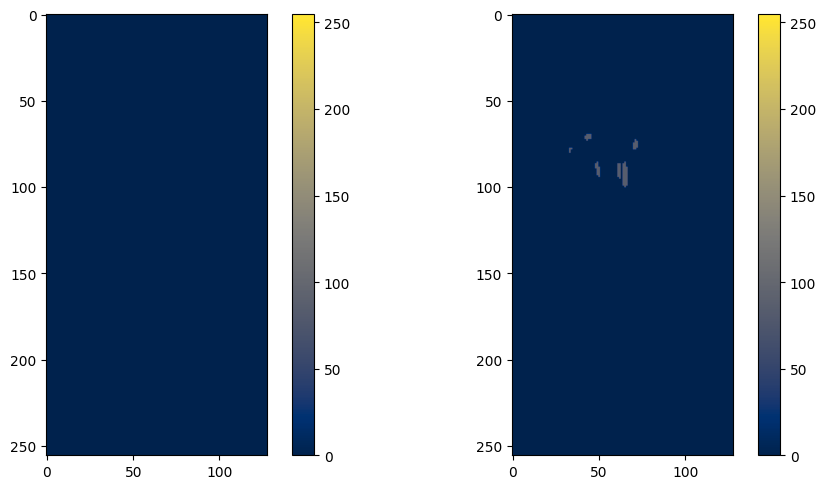

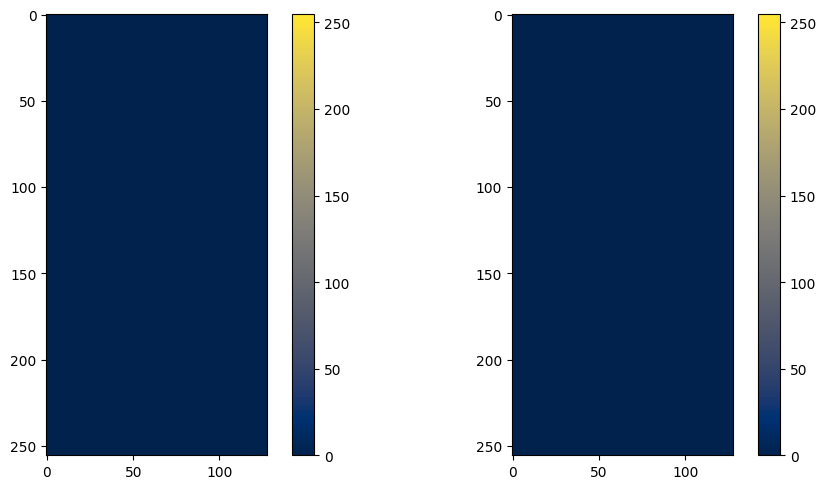

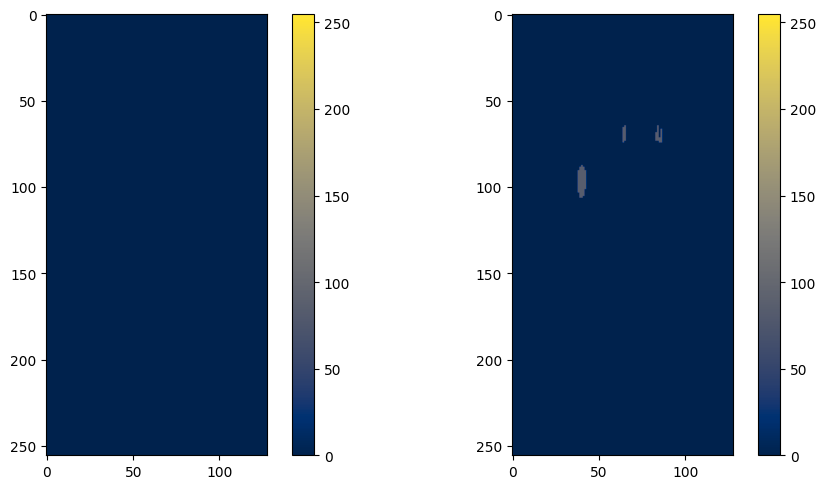

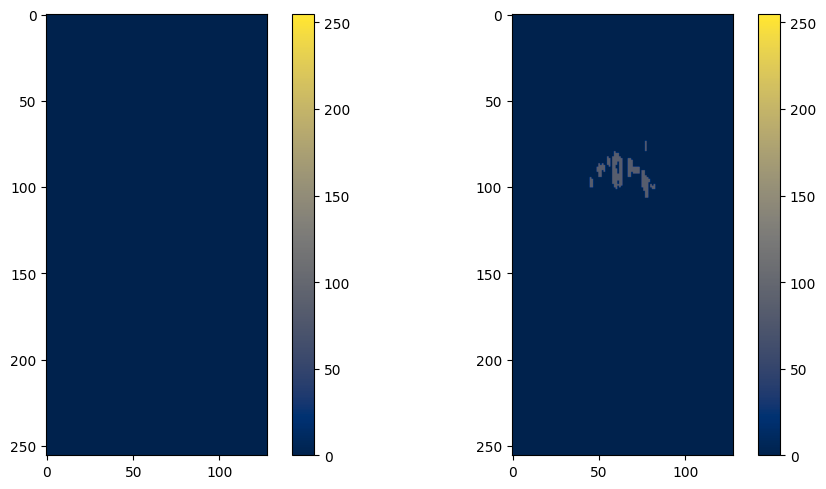

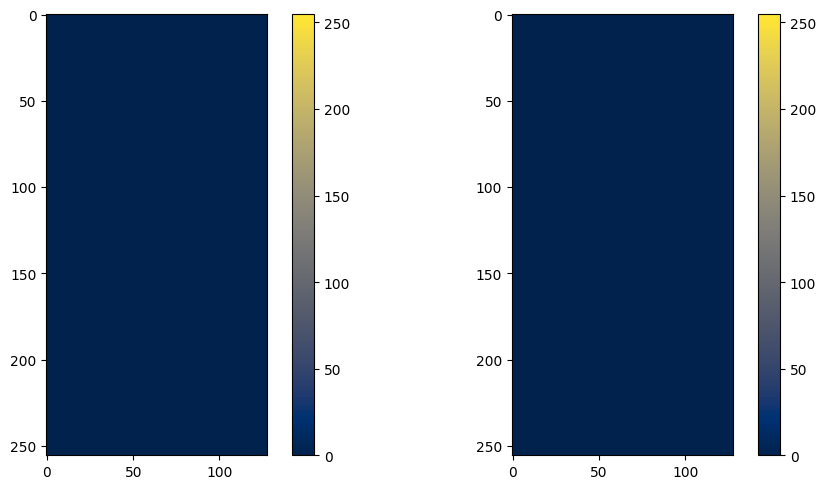

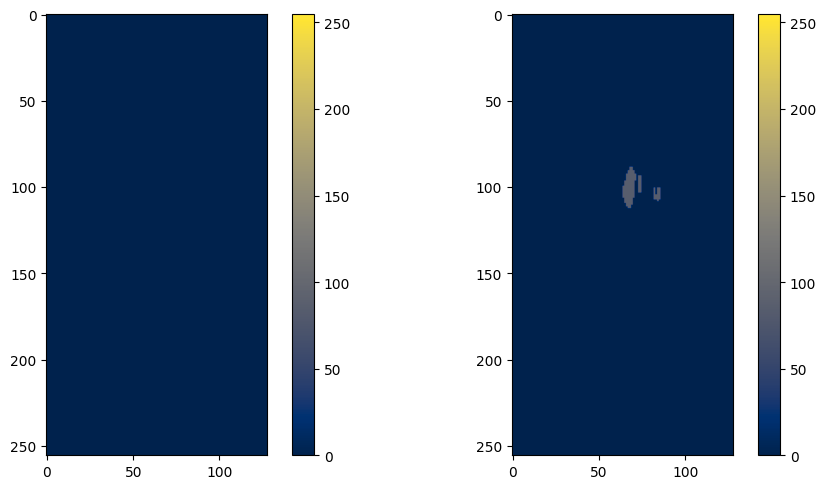

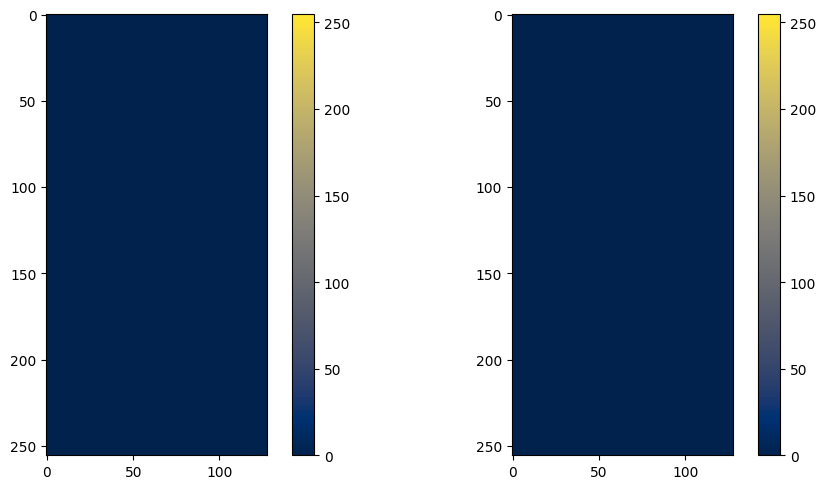

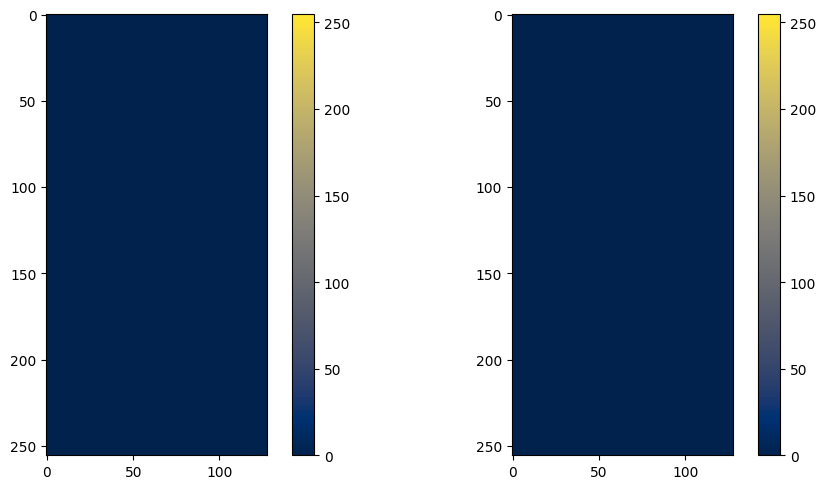

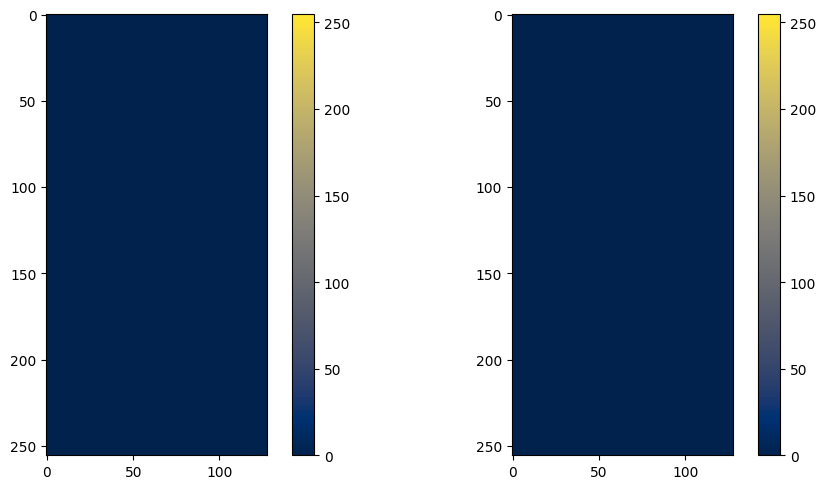

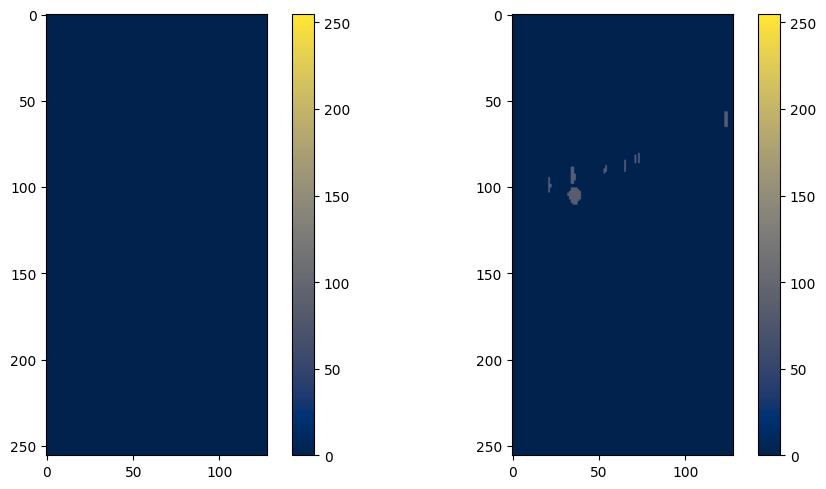

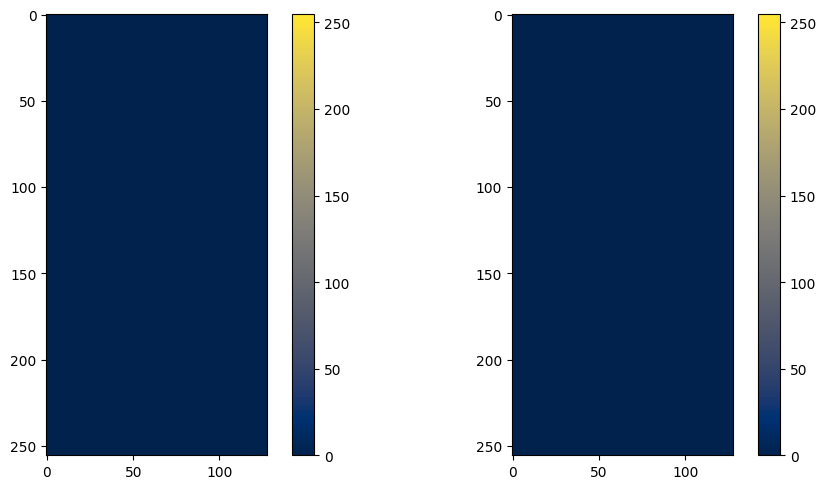

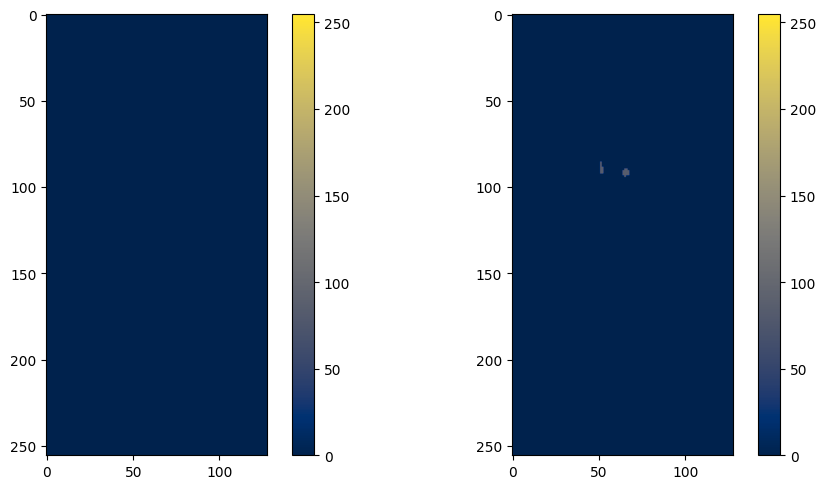

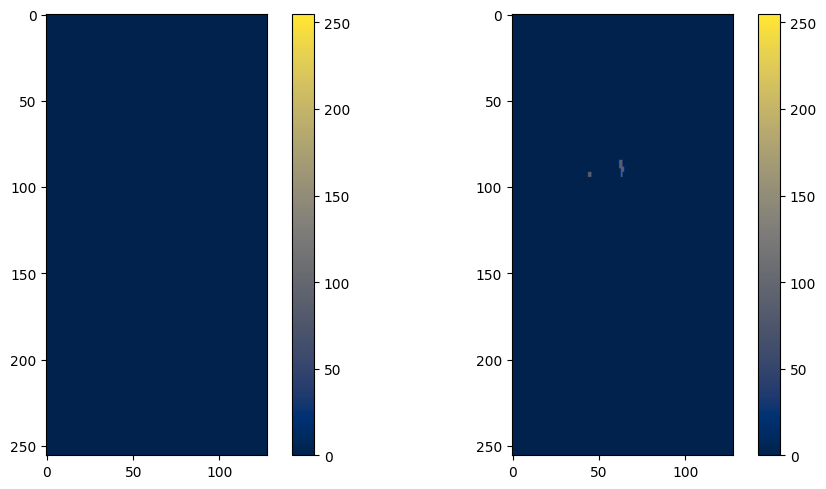

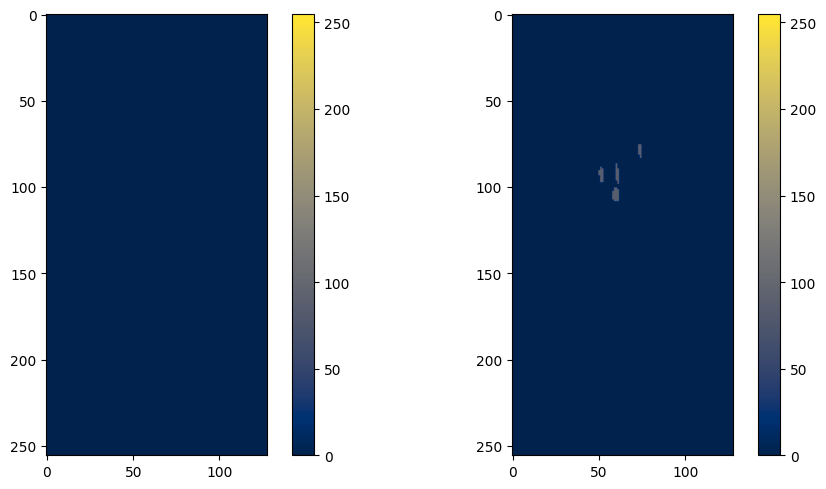

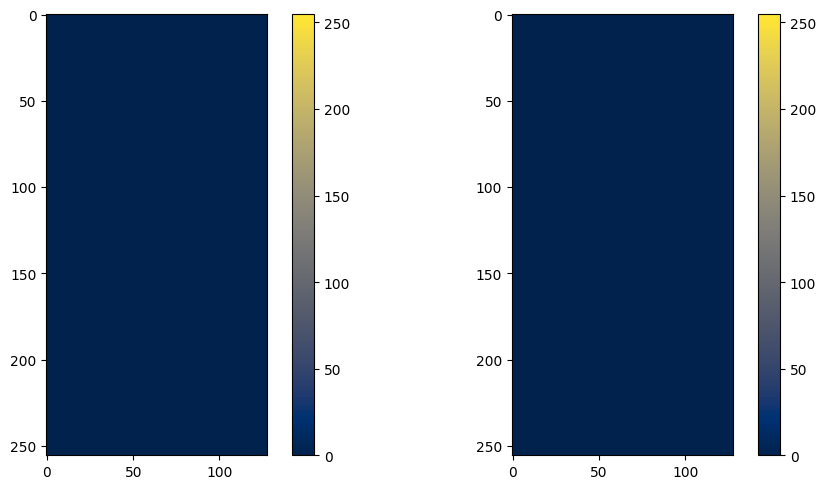

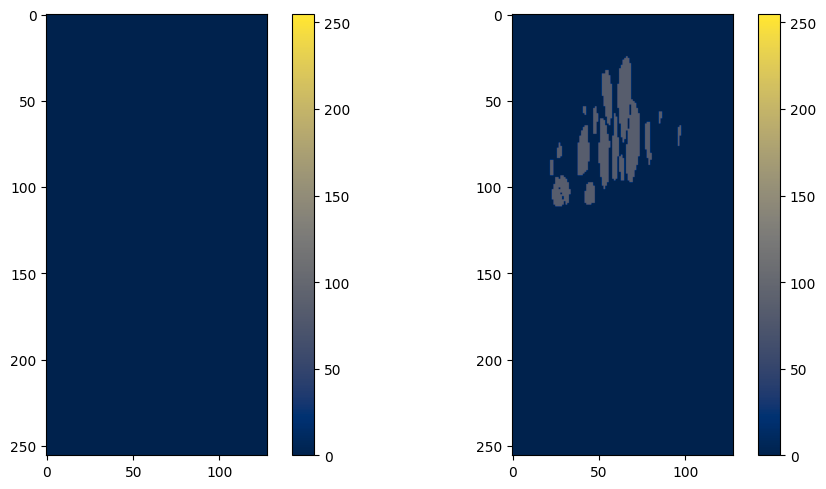

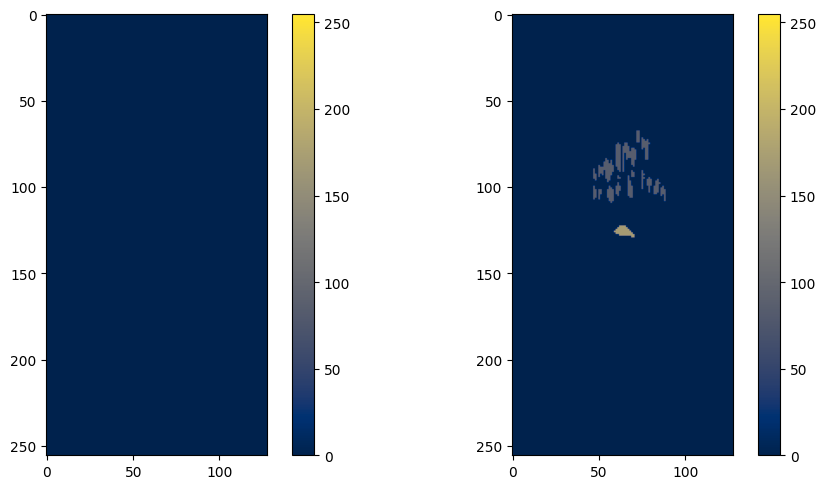

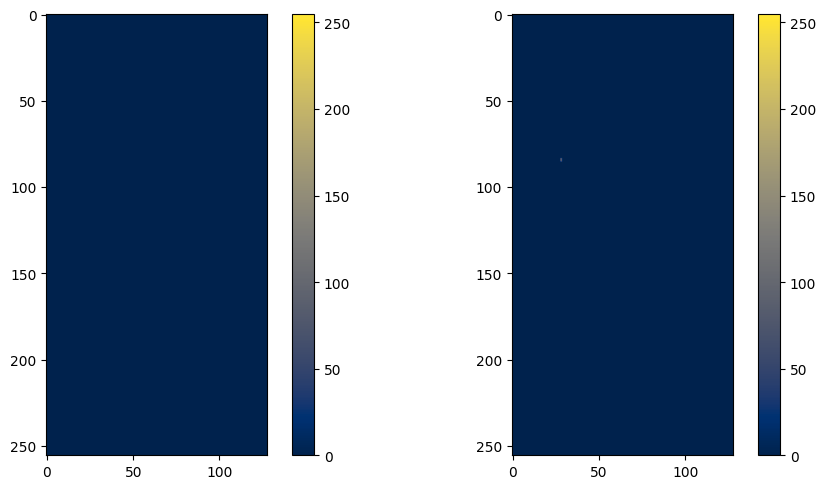

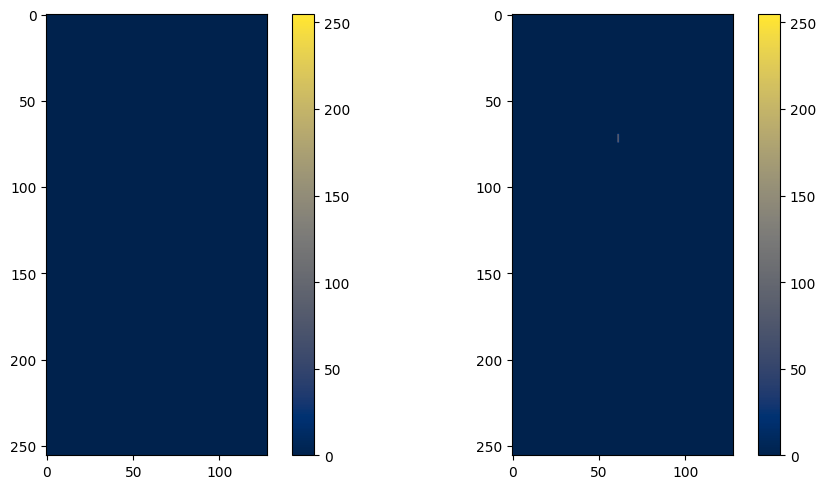

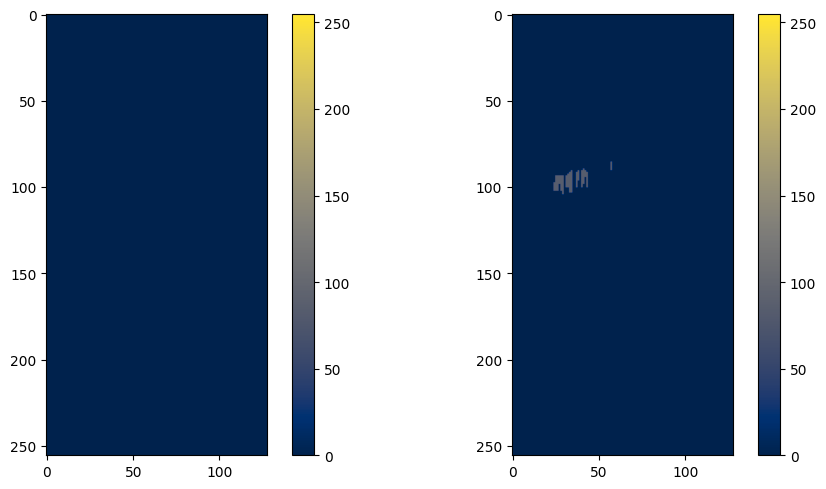

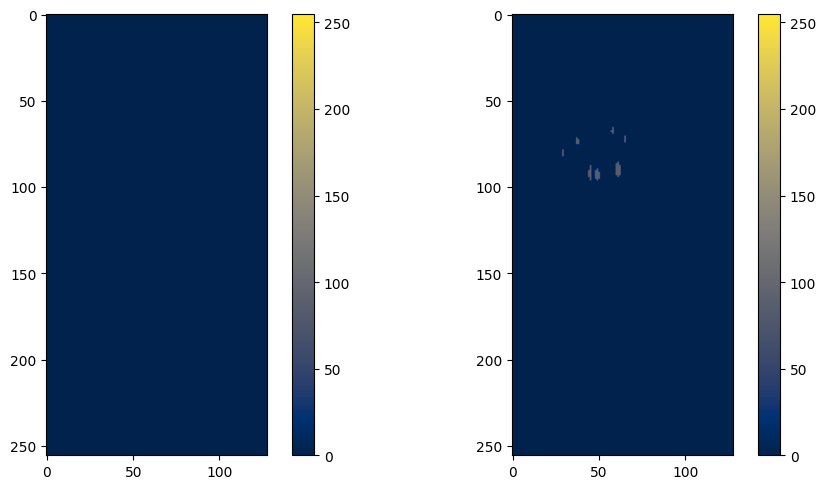

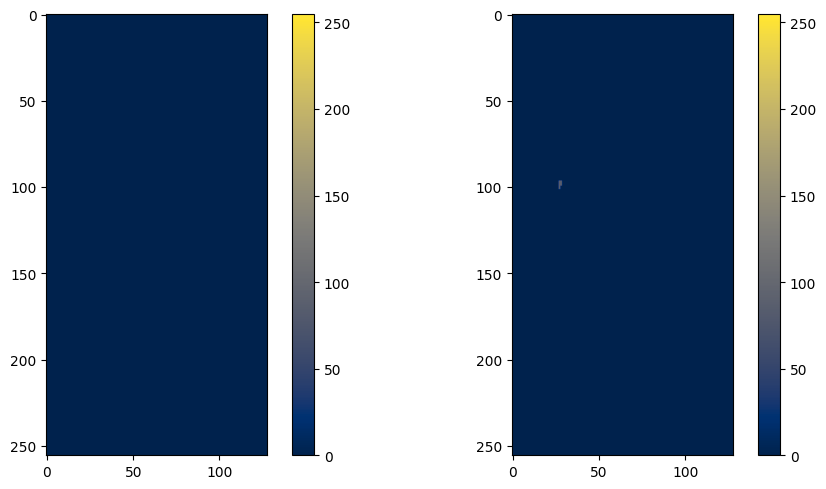

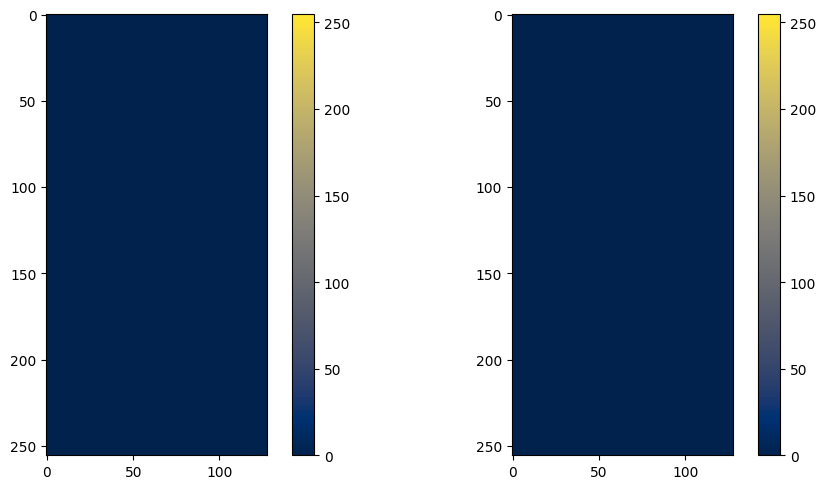

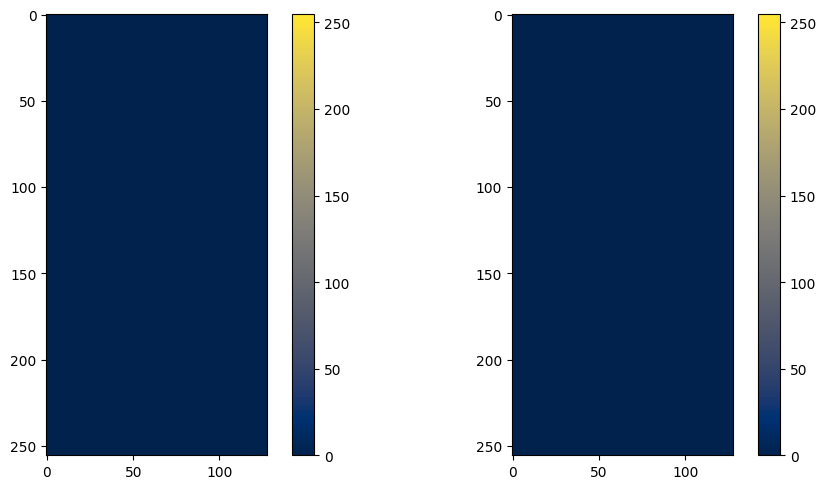

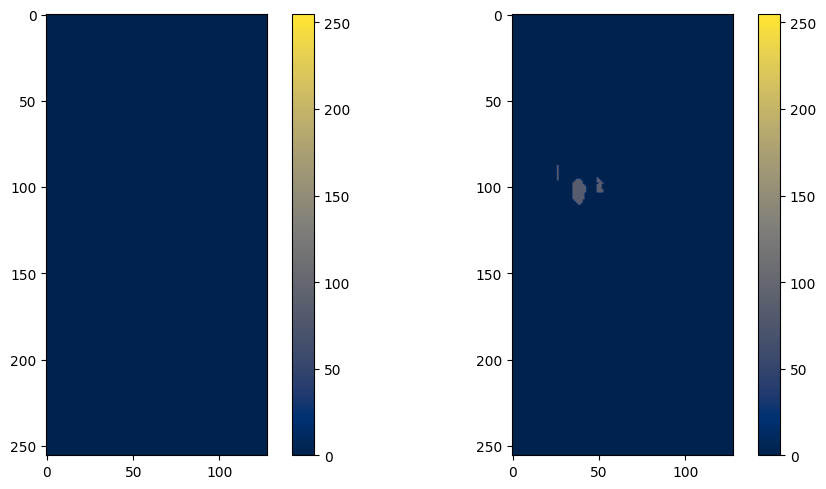

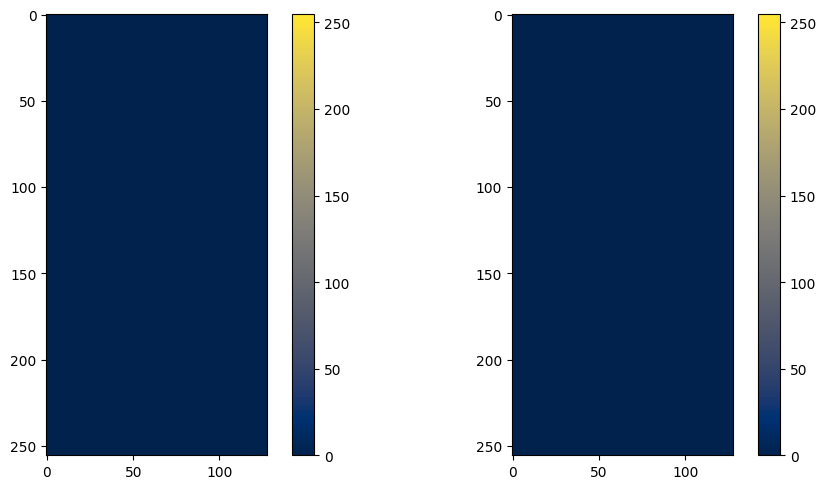

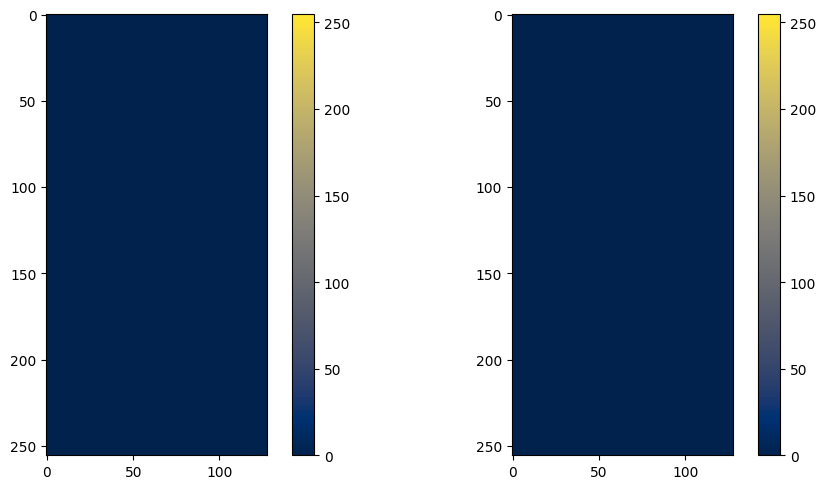

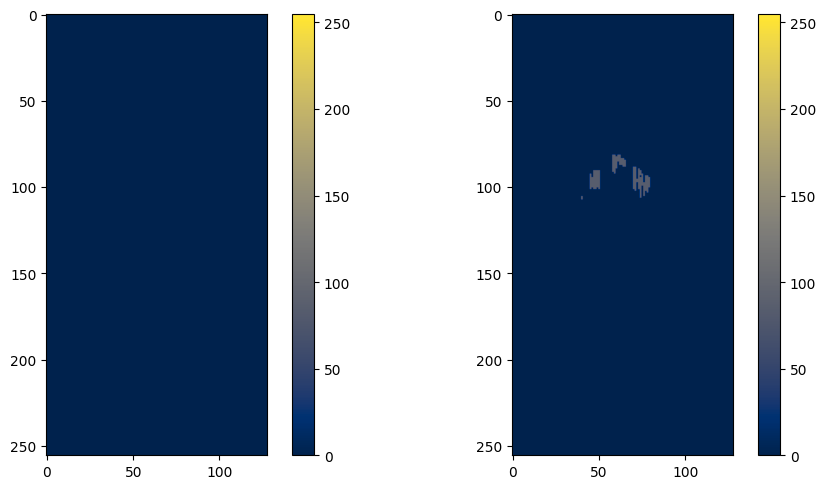

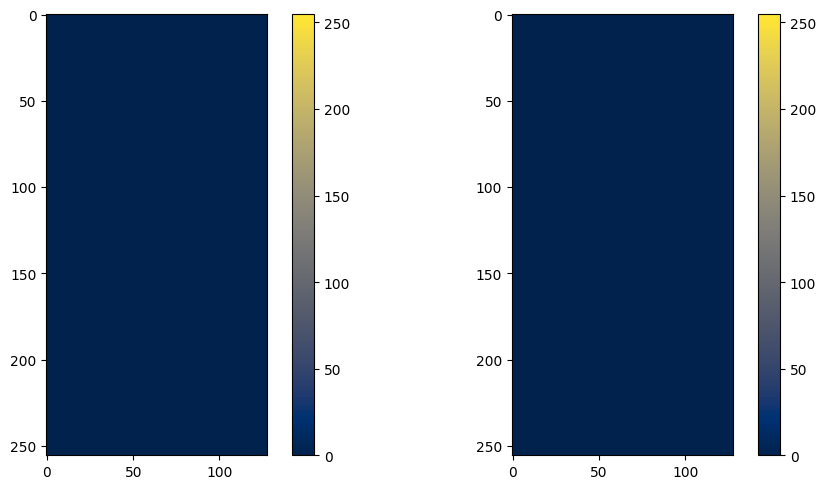

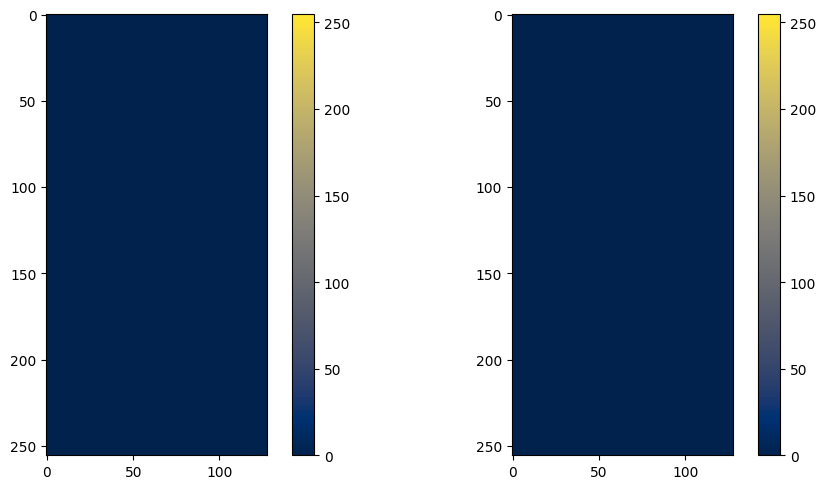

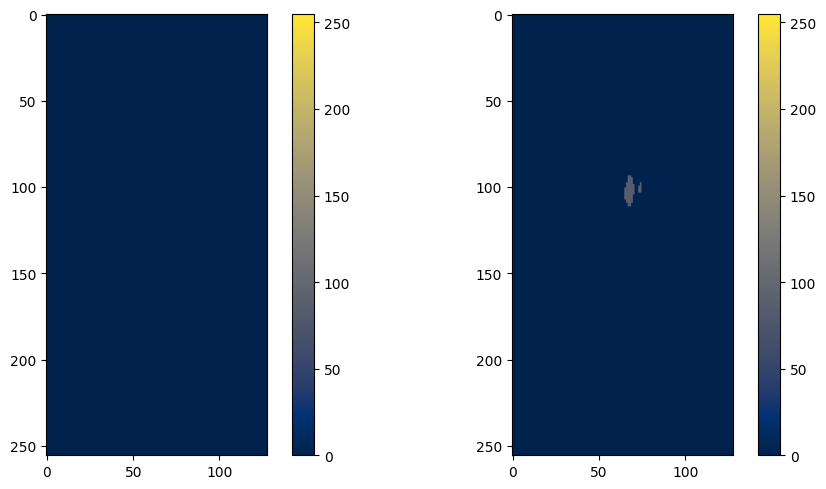

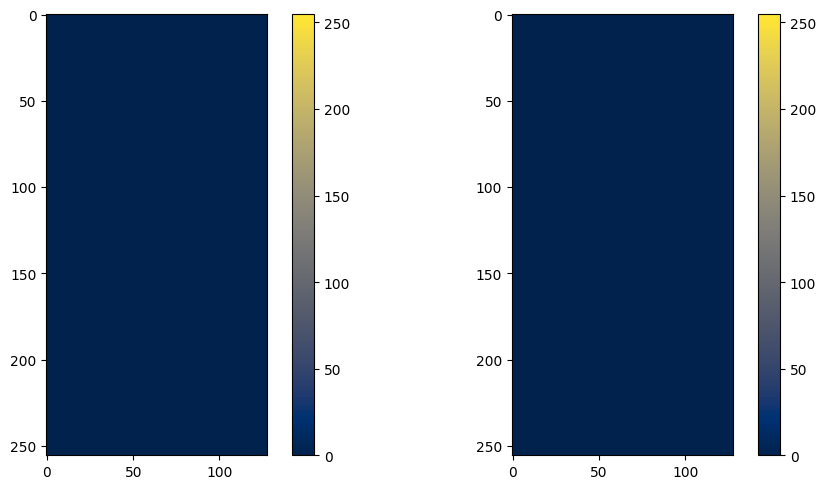

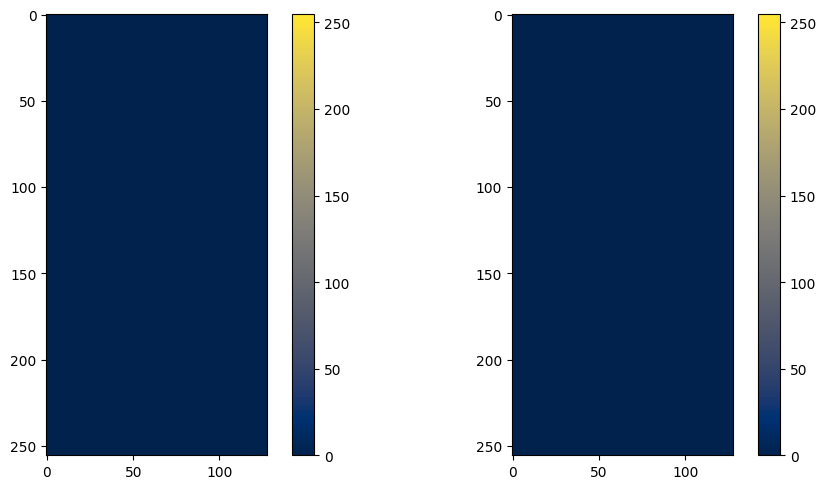

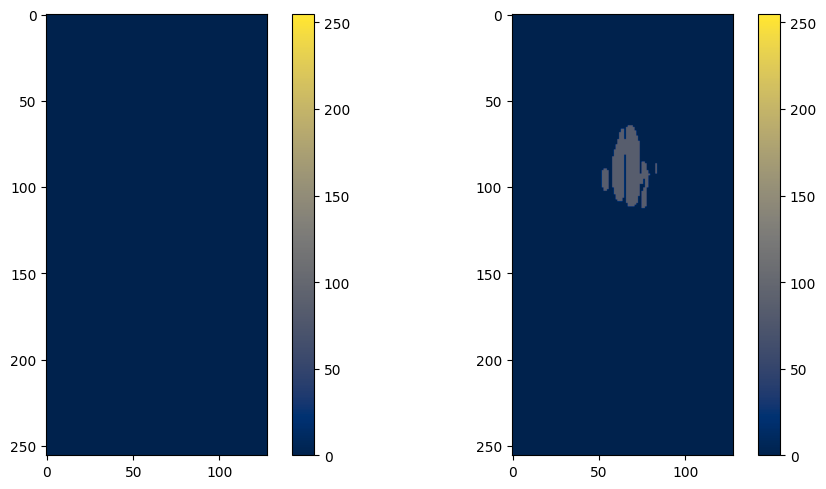

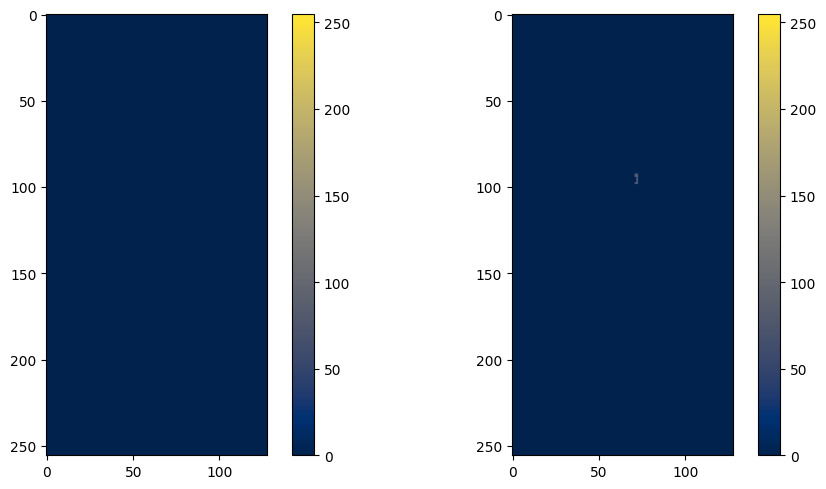

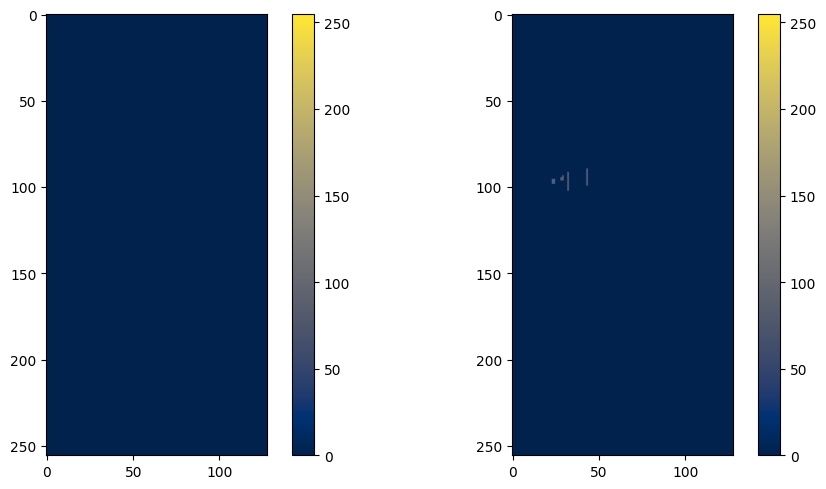

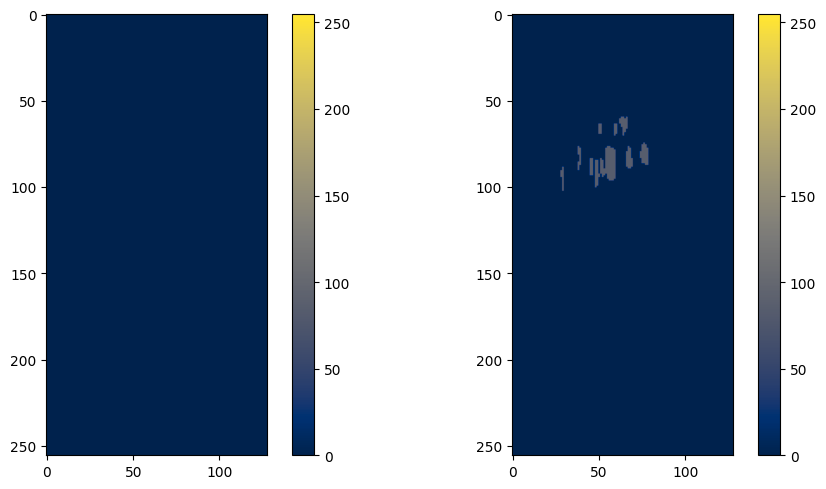

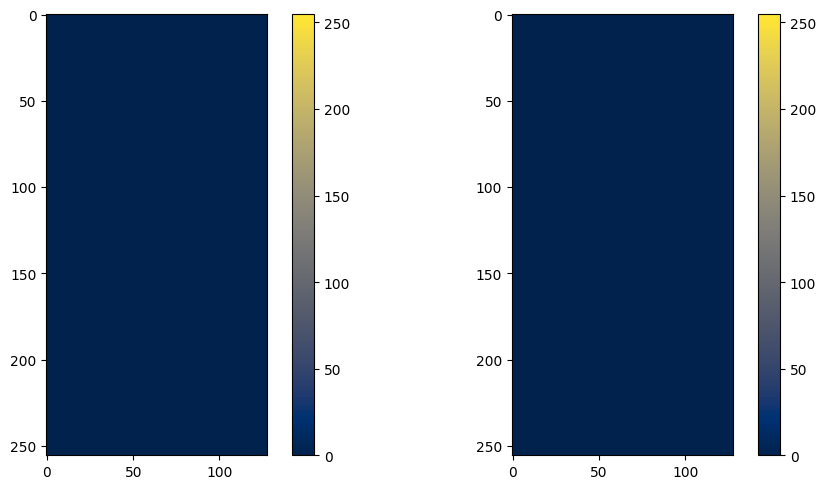

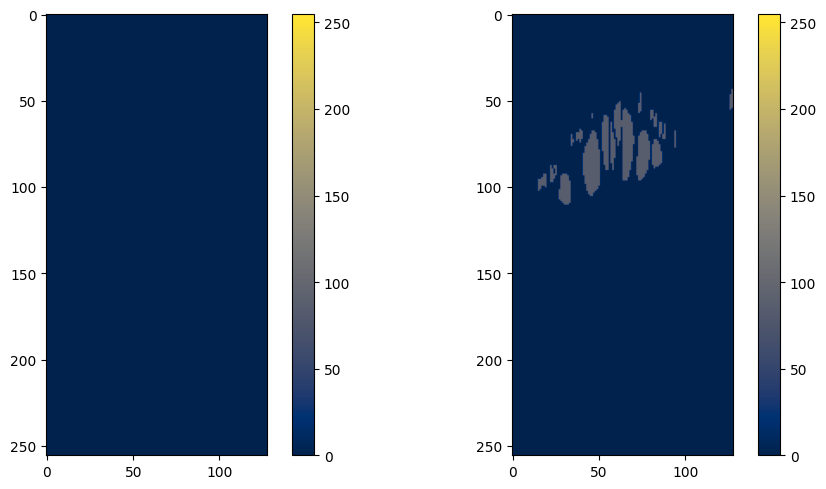

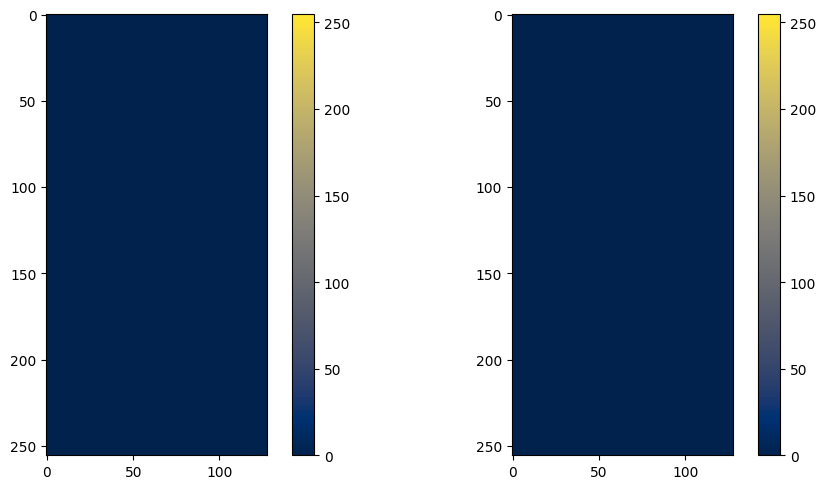

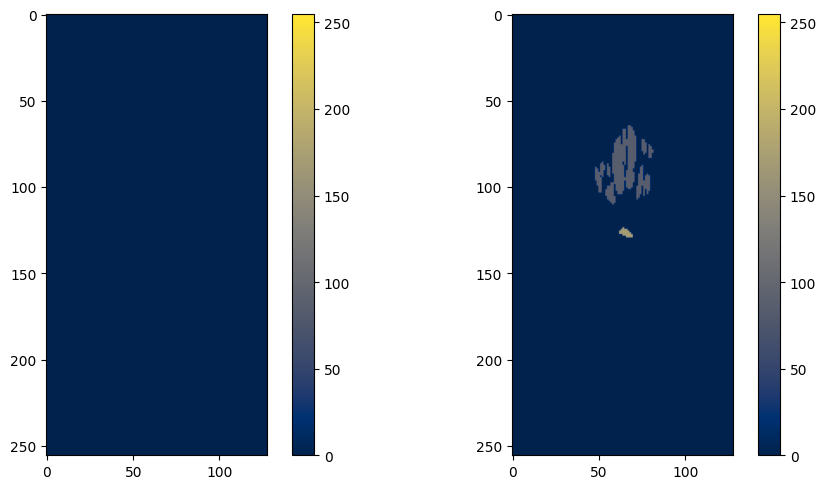

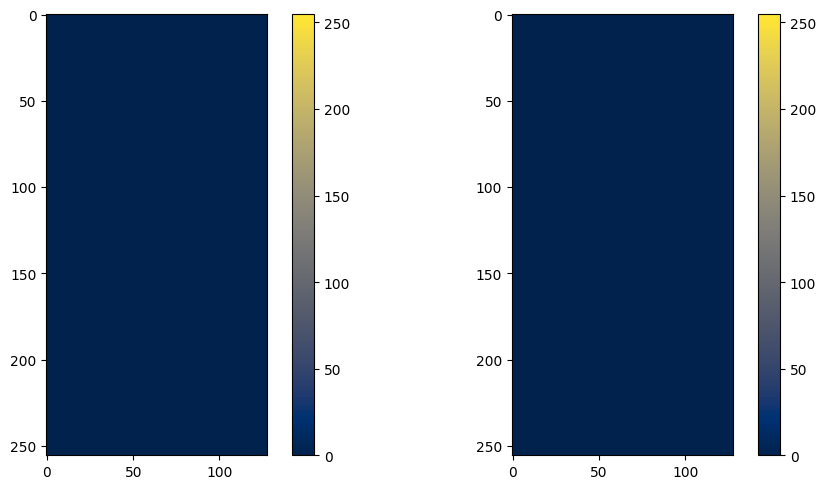

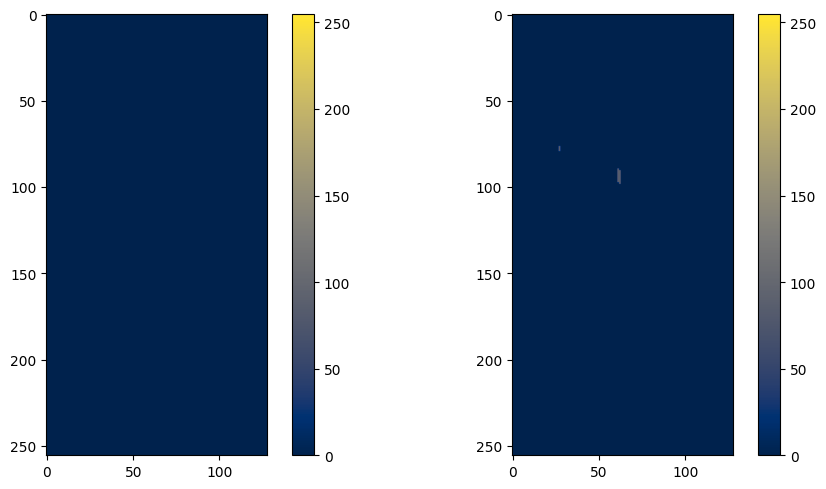

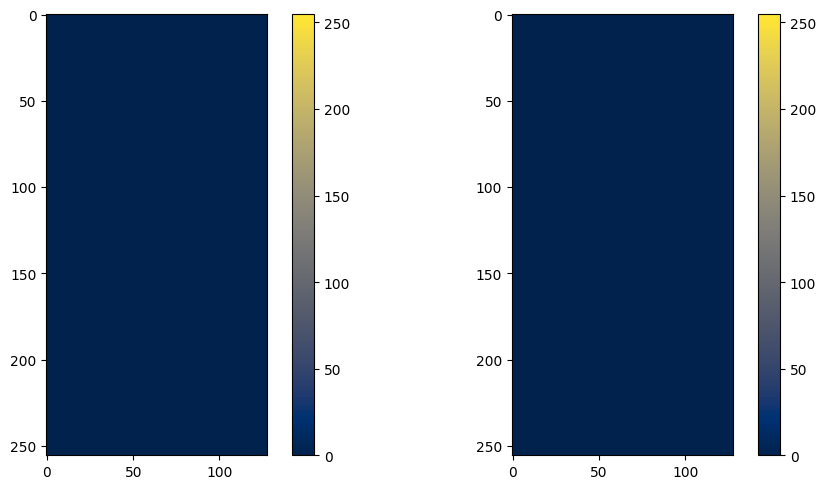

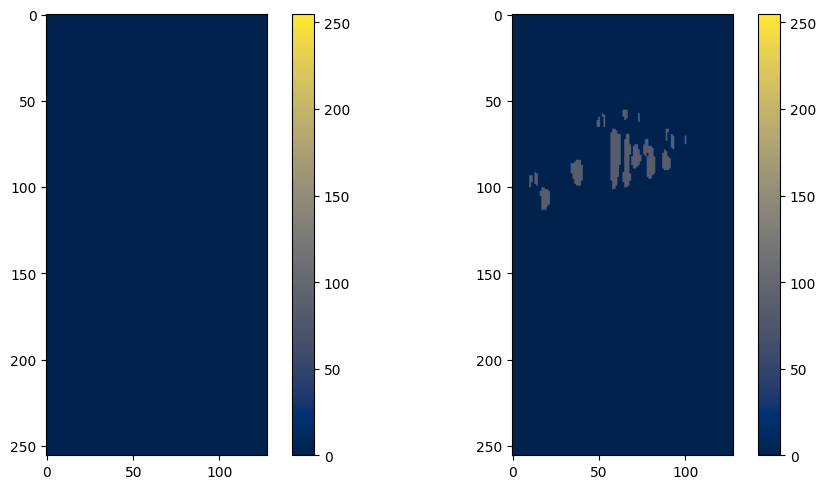

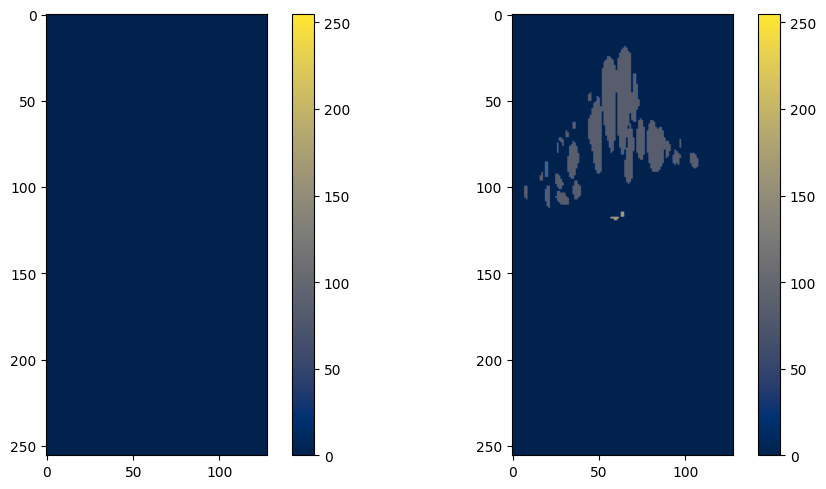

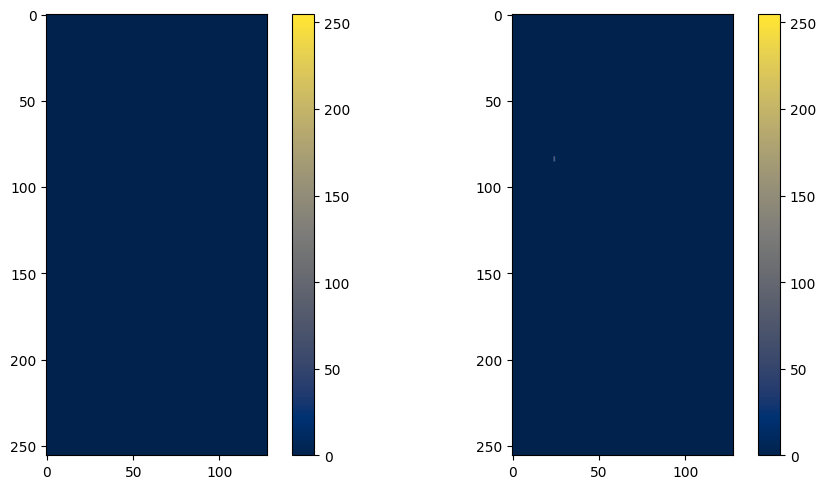

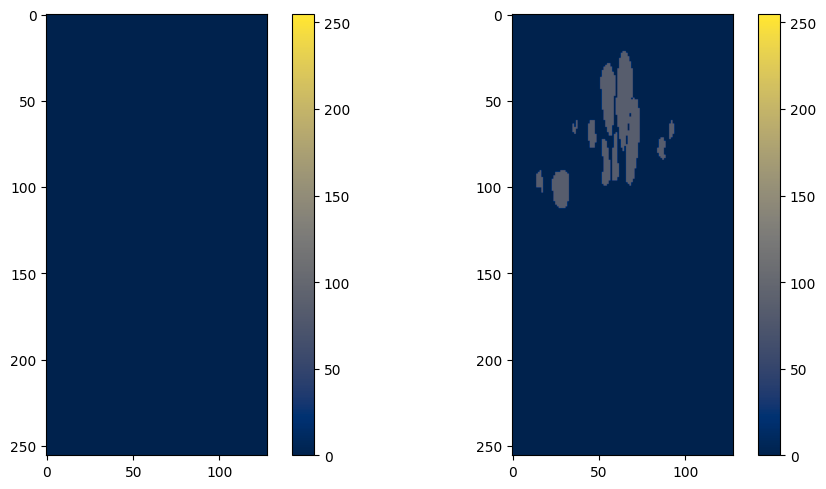

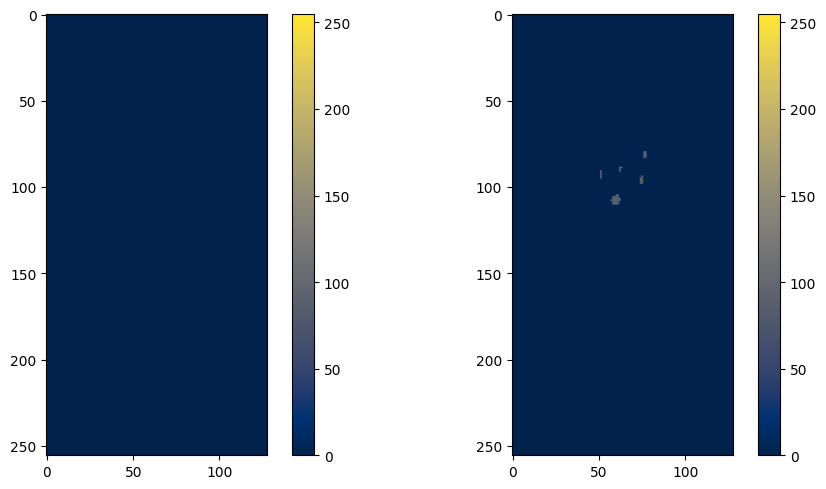

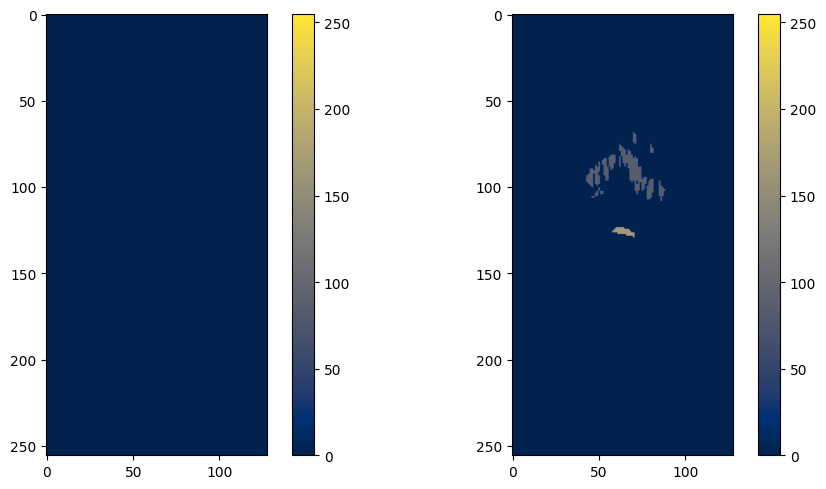

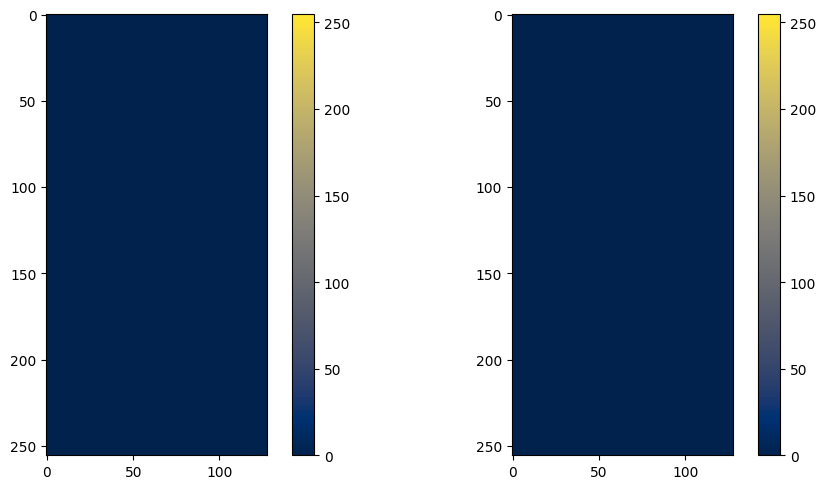

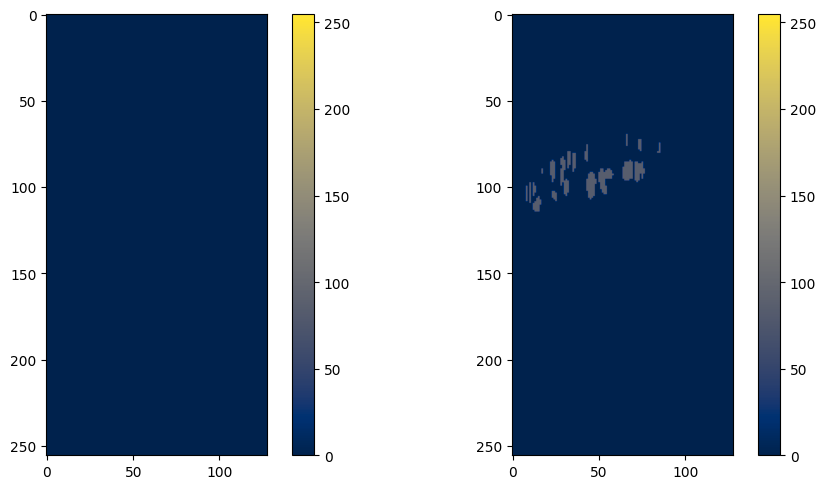

In [36]:
for i in range(len(predictions)):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(predictions[i]*85, cmap='cividis', vmin=0, vmax=255)  # Display the Predicted image in the batch
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(y_test[i]*85, cmap="cividis", vmin=0, vmax=255) # Display the Ground Truth
    plt.colorbar()
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()